In [1]:
import json
import requests
from bs4 import BeautifulSoup, Comment
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

### Data crawling 
The data source for this project is at https://fbref.com/en. After spending some time on the website, i was able to identify the key performance metrics for the players. Particularly, i learnt that some statistics might be repeated across several tables. Therefore, i decided to create a JSON file to store the metadata of each table, including their URL, HTML structure, and unique columns. This allows for independency between data source and programming, better managment, as well as cleaner code.

In [3]:
with open(".json", "r") as file:
    source_dict = json.load(file)

SOURCE_URL, STATISTICS_DICT = source_dict["source_url"], source_dict["statistics"]
stats = None

for key, value in STATISTICS_DICT.items():
    container_divs = value["container-divs"]
    columns = value["columns"]

    response = requests.get(SOURCE_URL.format(key))
    html = BeautifulSoup(response.text, features="html.parser")

    stats_div = html.find("body").find(id="wrap").find(id="content").find(id=container_divs[0])
    comment = stats_div.find(string=lambda text: isinstance(text, Comment))
    table = BeautifulSoup(comment, features="html.parser").find(id=container_divs[1]).find("table")

    tr_list = table.find("tbody").find_all("tr")
    tr_list = [tr for tr in tr_list if not tr.has_attr("class")]
    stats_list = []
    for tr in tr_list:
        player_stats = {td.get("data-stat"): td.text for td in tr.find_all("td") if td.get("data-stat") in columns}
        stats_list.append(player_stats)

    if isinstance(stats, pd.DataFrame):
        stats = stats.merge(
            pd.DataFrame(stats_list).set_index(["player", "team"]),
            on=["player", "team"],
            how="left"
        )
    else:
        stats = pd.DataFrame(stats_list).set_index(["player", "team"])
        stats["minutes"] = stats["minutes"].str.replace(",", "").astype(float)
        stats = stats[stats["minutes"] >= 90]

stats

,,nationality,position,age,minutes,goals_assists,goals_pens,npxg_xg_assist,goals_per90,assists_per90,goals_assists_per90,...,cards_red,fouls,fouled,offsides,crosses,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct
player,team,,,,,,,,,,,,,,,,,,,,,
Max Aarons,Bournemouth,eng ENG,DF,23,1237.0,1,0,0.9,0.00,0.07,0.07,...,0,12,26,2,13,0,75,5,11,31.3
Tyler Adams,Bournemouth,us USA,MF,24,121.0,0,0,0.1,0.00,0.00,0.00,...,0,0,3,0,1,0,7,2,3,40.0
Tosin Adarabioyo,Fulham,eng ENG,DF,25,1617.0,2,2,0.8,0.11,0.00,0.11,...,0,10,5,0,1,0,43,56,28,66.7
Elijah Adebayo,Luton Town,eng ENG,FW,25,1419.0,10,10,6.6,0.63,0.00,0.63,...,0,27,16,13,5,0,34,43,43,50.0
Simon Adingra,Brighton,ci CIV,FW,21,2222.0,7,6,8.0,0.24,0.04,0.28,...,0,29,19,17,76,0,118,8,12,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Nicolò Zaniolo,Aston Villa,it ITA,"FW,MF",24,839.0,2,2,3.6,0.21,0.00,0.21,...,0,24,21,0,18,0,36,7,14,33.3
Anass Zaroury,Burnley,ma MAR,"FW,MF",22,152.0,0,0,0.2,0.00,0.00,0.00,...,1,4,3,0,11,0,8,0,1,0.0
Oleksandr Zinchenko,Arsenal,ua UKR,DF,26,1722.0,3,1,3.1,0.05,0.10,0.16,...,0,7,9,1,30,0,104,27,16,62.8


### Data cleaning
- There is redundancy at the ***nationality*** column
- Since the data was read from an HTML response, all of the columns now are defined as string, which requires type conversion as the statistical data needs to be numerical for later use. Notably, the missing data is represented as blank

In [4]:
stats["nationality"] = stats["nationality"].str.replace(r"[a-z]", "", regex=True)
stats = stats.replace("", np.nan)

statistical_columns = stats.columns.difference(["nationality", "position"])
statistical_columns.name = "statistical_columns"
stats[statistical_columns] = stats[statistical_columns].astype(float)
stats.dtypes

nationality         object
position            object
age                float64
minutes            float64
goals_assists      float64
                    ...   
own_goals          float64
ball_recoveries    float64
aerials_won        float64
aerials_lost       float64
aerials_won_pct    float64
Length: 158, dtype: object

In [5]:
# stats.reset_index().sort_values(by=["player", "age"], ascending=[True, False]).set_index(["player", "team"]).to_csv("result/results.csv", index=True)

### Q1: Who are the top 3 players with the highest and lowest scores at each statistic?
Players are sorted from lowest (-3) to highest (3) in the following table

In [6]:
top_and_bottom_stats = pd.concat([
    stats[statistical_columns].apply(lambda col: col.nsmallest(3).sort_values().index.values).set_axis([-3, -2, -1]),
    stats[statistical_columns].apply(lambda col: col.nlargest(3).sort_values().index.values).set_axis([1, 2, 3])
])
top_and_bottom_stats

,aerials_lost,aerials_won,aerials_won_pct,age,assisted_shots,assists,assists_per90,average_shot_distance,ball_recoveries,blocked_passes,...,touches_live_ball,touches_mid_3rd,unused_subs,xg,xg_assist,xg_assist_net,xg_assist_per90,xg_net,xg_per90,xg_xg_assist_per90
-3,"(Daniel Bentley, Wolves)","(Maxwel Cornet, West Ham)","(Maxwel Cornet, West Ham)","(Leon Chiwome, Wolves)","(Jaidon Anthony, Bournemouth)","(Tyler Adams, Bournemouth)","(Tyler Adams, Bournemouth)","(Tim Ream, Fulham)","(Loris Karius, Newcastle Utd)","(Alisson, Liverpool)",...,"(Leon Chiwome, Wolves)","(Dean Henderson, Crystal Palace)","(Elijah Adebayo, Luton Town)","(Max Aarons, Bournemouth)","(Naouirou Ahamada, Crystal Palace)","(Dejan Kulusevski, Tottenham)","(Alisson, Liverpool)","(Dominic Calvert-Lewin, Everton)","(Max Aarons, Bournemouth)","(Alisson, Liverpool)"
-2,"(Martin Dúbravka, Newcastle Utd)","(Mahmoud Dahoud, Brighton)","(Mahmoud Dahoud, Brighton)","(Lewis Miley, Newcastle Utd)","(Alphonse Areola, West Ham)","(Tosin Adarabioyo, Fulham)","(Tosin Adarabioyo, Fulham)","(Andrew Omobamidele, Nott'ham Forest)","(Ionuț Radu, Bournemouth)","(Alphonse Areola, West Ham)",...,"(Neal Maupay, Everton)","(Loris Karius, Newcastle Utd)","(Anel Ahmedhodžić, Sheffield Utd)","(Tyler Adams, Bournemouth)","(Alisson, Liverpool)","(Bruno Fernandes, Manchester Utd)","(Jaidon Anthony, Bournemouth)","(Brennan Johnson, Tottenham)","(Tyler Adams, Bournemouth)","(Alphonse Areola, West Ham)"
-1,"(Ederson, Manchester City)","(Tommy Doyle, Wolves)","(Tommy Doyle, Wolves)","(Facundo Buonanotte, Brighton)","(Daniel Bentley, Wolves)","(Elijah Adebayo, Luton Town)","(Elijah Adebayo, Luton Town)","(Jonny Evans, Manchester Utd)","(Thomas Strakosha, Brentford)","(Daniel Bentley, Wolves)",...,"(Loris Karius, Newcastle Utd)","(Ionuț Radu, Bournemouth)","(Rayan Aït-Nouri, Wolves)","(Alisson, Liverpool)","(Jaidon Anthony, Bournemouth)","(Dominik Szoboszlai, Liverpool)","(Alphonse Areola, West Ham)","(Darwin Núñez, Liverpool)","(Alisson, Liverpool)","(Daniel Bentley, Wolves)"
1,"(Dominic Solanke, Bournemouth)","(Dominic Calvert-Lewin, Everton)","(Daniel Bentley, Wolves)","(Łukasz Fabiański, West Ham)","(Martin Ødegaard, Arsenal)","(Kevin De Bruyne, Manchester City)","(Kevin De Bruyne, Manchester City)","(Moisés Caicedo, Chelsea)","(Ryan Christie, Bournemouth)","(João Palhinha, Fulham)",...,"(Lewis Dunk, Brighton)","(William Saliba, Arsenal)","(Aaron Ramsdale, Arsenal)","(Alexander Isak, Newcastle Utd)","(Bruno Fernandes, Manchester Utd)","(Pedro Neto, Wolves)","(Sasa Kalajdzic, Wolves)","(Jean-Philippe Mateta, Crystal Palace)","(Erling Haaland, Manchester City)","(Erling Haaland, Manchester City)"
2,"(Dominic Calvert-Lewin, Everton)","(James Tarkowski, Everton)","(Martin Dúbravka, Newcastle Utd)","(Thiago Silva, Chelsea)","(Pascal Groß, Brighton)","(Cole Palmer, Chelsea)","(Ivan Perišić, Tottenham)","(Kyle Walker, Manchester City)","(Rodri, Manchester City)","(Tyrick Mitchell, Crystal Palace)",...,"(Pascal Groß, Brighton)","(Virgil van Dijk, Liverpool)","(Thomas Strakosha, Brentford)","(Mohamed Salah, Liverpool)","(Son Heung-min, Tottenham)","(Rodri, Manchester City)","(Ivan Perišić, Tottenham)","(Callum Hudson-Odoi, Nott'ham Forest)","(Neal Maupay, Everton)","(Neal Maupay, Everton)"
3,"(Carlton Morris, Luton Town)","(Virgil van Dijk, Liverpool)","(Ederson, Manchester City)","(Ashley Young, Everton)","(Bruno Fernandes, Manchester Utd)","(Ollie Watkins, Aston Villa)","(Manor Solomon, Tottenham)","(Oliver Norwood, Sheffield Utd)","(Bruno Guimarães, Newcastle Utd)","(Alexis Mac Allister, Liverpool)",...,"(Rodri, Manchester City)","(Rodri, Manchester City)","(Daniel Bentley, Wolves)","(Erling Haaland, Manchester City)","(Mohamed Salah, Liverpool)","(Ollie Watkins, Aston Villa)","(Kevin De Bruyne, Manchester City)","(Phil Foden, Manchester City)","(Kieffer Moore, Bournemouth)","(Kieffer Moore, Bournemouth)"


### Q2: Which team is performing the best overall during the season?
#### 1. Caculate median, mean and standard deviation for every statistic in each team

In [25]:
statistics = ["median", "mean", "std"]

all_team_stats = pd.DataFrame(
    [stats[statistical_columns].agg(statistics).T.to_numpy().flatten()],
    columns=pd.MultiIndex.from_product([statistical_columns.array, statistics]),
    index=pd.Index(["All"], name="team")
)

team_stats = pd.concat([
    all_team_stats,
    stats[statistical_columns].groupby(level="team").agg(statistics)
])
team_stats

aerials_lost                       aerials_won             \
                      median       mean        std      median       mean   
team                                                                        
All                     16.0  20.402834  20.973606        12.0  20.447368   
Arsenal                 16.0  23.619048  24.830377        15.0  23.809524   
Aston Villa             14.0  15.695652  16.457755        13.0  14.478261   
Bournemouth             21.0  25.653846  29.389716        15.0  22.192308   
Brentford               23.0  24.000000  16.849827        14.0  25.240000   
Brighton                11.5  12.214286   8.808065         7.5  14.464286   
Burnley                 22.0  24.714286  23.325169        13.5  20.035714   
Chelsea                 14.0  15.880000  13.860375         9.0  17.120000   
Crystal Palace          17.0  23.125000  20.749673        12.5  22.916667   
Everton                 19.0  25.086957  31.137398        16.0  29.391304   
Fulham                  19.0  23.666667  23.789353        13.0  22.809524   
Liverpool               14.0  19.954545  14.486372        15.5  26.454545   
Luton Town              16.0  25.200000  33.117216        17.0  25.400000   
Manchester City          8.0  13.666667  13.312901         6.0  15.476190   
Manchester Utd          18.0  17.115385  14.182600        13.5  16.769231   
Newcastle Utd           12.0  16.440000  16.416658        10.0  18.080000   
Nott'ham Forest         10.0  18.500000  21.634503        14.0  19.366667   
Sheffield Utd           16.0  23.066667  23.619007         8.0  19.500000   
Tottenham               14.5  15.916667  14.303896         8.5  14.750000   
West Ham                23.0  25.590909  23.526397        20.0  25.909091   
Wolves                  21.0  19.640000  14.679578         8.0  17.640000   

                           aerials_won_pct                          age  ...  \
                       std          median       mean        std median  ...   
team                                                                     ...   
All              23.820838           46.90  48.338809  21.536946   25.0  ...   
Arsenal          28.002891           48.80  48.830000  21.108868   24.0  ...   
Aston Villa      12.943477           50.00  53.656522  22.613669   26.0  ...   
Bournemouth      23.901497           42.10  45.768000  21.677518   24.5  ...   
Brentford        26.833251           45.60  46.050000  17.682957   26.0  ...   
Brighton         17.045651           45.70  47.935714  23.503683   23.5  ...   
Burnley          26.141328           43.75  40.807143  22.099069   24.0  ...   
Chelsea          17.965986           47.20  49.976000  22.813707   22.0  ...   
Crystal Palace   24.207287           48.50  50.266667  17.860514   25.5  ...   
Everton          40.626614           47.20  47.827273  21.788489   26.0  ...   
Fulham           19.314811           52.20  50.238095  16.172368   27.0  ...   
Liverpool        30.722610           53.60  54.268182  20.368262   24.0  ...   
Luton Town       27.605857           50.00  53.168000  19.891408   26.0  ...   
Manchester City  17.965576           50.00  49.730000  25.445175   27.0  ...   
Manchester Utd   15.895427           44.95  47.261538  20.292562   25.5  ...   
Newcastle Utd    23.575976           47.70  51.170833  22.582168   26.0  ...   
Nott'ham Forest  18.219889           54.50  55.796552  19.339384   25.5  ...   
Sheffield Utd    26.502765           45.35  41.666667  19.709937   24.0  ...   
Tottenham        18.531407           38.50  41.500000  24.102408   25.5  ...   
West Ham         26.354559           50.95  50.490909  23.849307   27.5  ...   
Wolves           21.990301           41.90  43.344000  25.282818   24.0  ...   

                xg_assist_per90 xg_net                         xg_per90  \
                            std median          mean       std   median   
team                                                                      
All                  

In [30]:
# team_stats.to_csv("result/results2.csv", index=True)

#### 2. Visualize the distribution of each statistic for every team

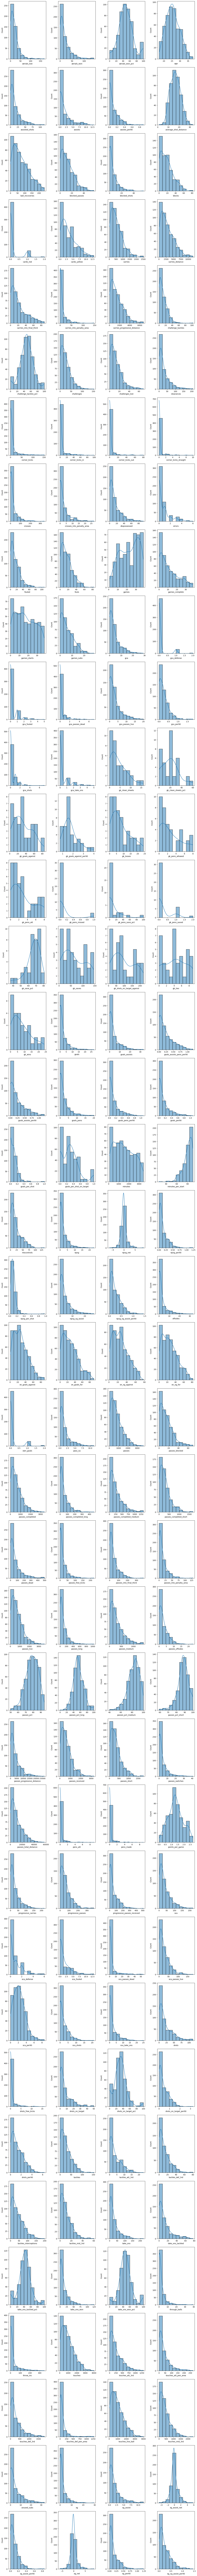

In [29]:
AXES_PER_ROW = 4
num_rows = (statistical_columns.size + AXES_PER_ROW - 1) // AXES_PER_ROW
fig, axes = plt.subplots(num_rows, AXES_PER_ROW, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, column in enumerate(statistical_columns):
    sns.histplot(stats[column], ax=axes[i], bins=10, kde=True)
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### 3. Identify the team with the highest score at each statistic

In [32]:
top_team_stats = stats[statistical_columns].groupby(level="team").agg("mean").apply(lambda col: col.idxmax()).to_frame().T
top_team_stats

,aerials_lost,aerials_won,aerials_won_pct,age,assisted_shots,assists,assists_per90,average_shot_distance,ball_recoveries,blocked_passes,...,touches_live_ball,touches_mid_3rd,unused_subs,xg,xg_assist,xg_assist_net,xg_assist_per90,xg_net,xg_per90,xg_xg_assist_per90
0,Bournemouth,Everton,Nott'ham Forest,West Ham,Liverpool,Manchester City,Tottenham,Burnley,Liverpool,Liverpool,...,Manchester City,Manchester City,Manchester City,Liverpool,Liverpool,Manchester City,Tottenham,Manchester City,Everton,Manchester City
